In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



np.random.seed(42)

# Load the graph

In [5]:
# beta should be higher than c
n = 500 # number of nodes - 585 similar to c elegans
p = 0  # number of neighbouts to take into account

alpha = 5    #  negative 0.003
beta  = 5    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = np.log(1/1e-3 - 1)    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 3
warm_up     = 3

################################################
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [6]:
ut  = utils.GraphUtils()

graphs, spectra = ut.loading_graph_artifacts(params_dict)

# Estimation

In [102]:
g = graphs[-1]
s = spectra[-1]

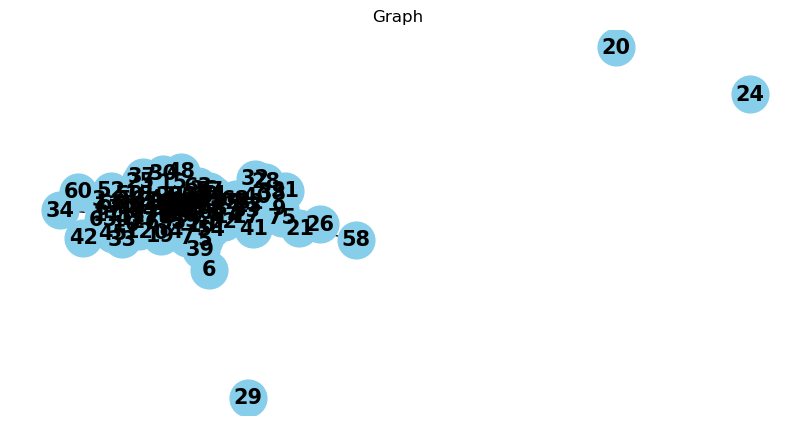

In [87]:
ut.plot_graph_from_adjacency(g, pos=None, title='Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


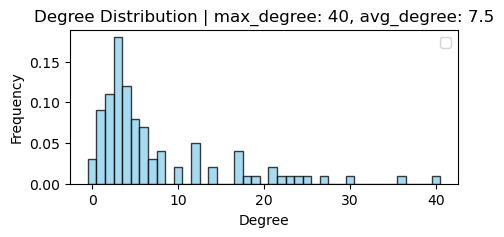

In [88]:
ut.plot_degree_distribution(g, title='Degree Distribution', size=(5,2))

In [89]:
initial_guess = [0,0,0]
est = estimator.MLEGraphModelEstimator(g)

a_hat, b_hat, s_hat = est.estimate_parameters_torch(initial_guess=initial_guess, learning_rate=0.001, max_iter=30)

Current parameters: alpha=4.22047758102417, beta=14.415905952453613, sigma=2.3819937705993652, Loss=3500.2373046875
Current parameters: alpha=nan, beta=nan, sigma=nan, Loss=1650.120849609375
Current parameters: alpha=nan, beta=nan, sigma=nan, Loss=nan


KeyboardInterrupt: 

In [ ]:
print(a_hat,b_hat,s_hat)
print(alpha, beta, sigma)

0.1823902726173401 0.5256756544113159 1.8326225280761719
-0.3 -0.3 -6.907755278982137


## Plot

In [60]:
c_values = np.linspace(0.000001, 2, 100)
beta_values = np.linspace(0.000001, 2, 100)

likelihood = np.empty((len(c_values), len(beta_values)))
for i, ci in enumerate(c_values):
    for j, betaj in enumerate(beta_values):
        likelihood[i, j] = est.likelihood_function([ci, betaj])


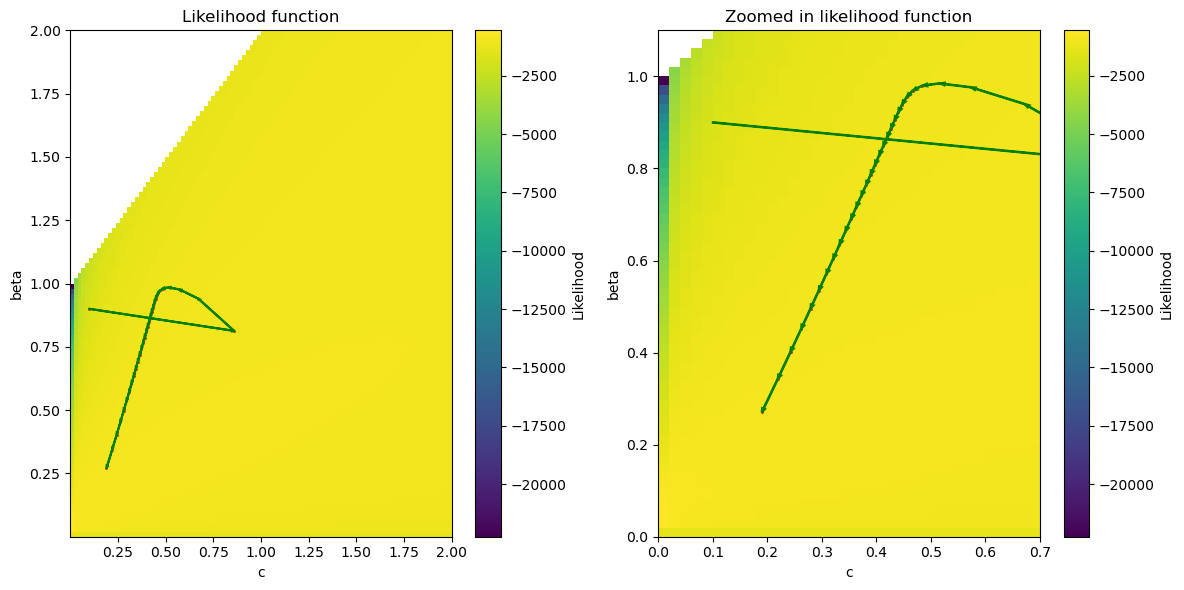

In [111]:
params_history = np.array([initial_guess]+est.params_history)

# Convert the parameters to the corresponding indices in the c_values and beta_values arrays
c_indices = params_history[:, 0]
beta_indices = params_history[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the full heatmap on the first subplot
im = axs[0].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im, ax=axs[0], label='Likelihood')
axs[0].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[0].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[0].set_xlabel('c')
axs[0].set_ylabel('beta')
axs[0].set_title('Likelihood function')

# Plot a zoomed in region on the second subplot
zoom_c_min, zoom_c_max = 0, 0.7  # Adjust these values to zoom in on the desired region
zoom_beta_min, zoom_beta_max = 0, 1.1  # Adjust these values to zoom in on the desired region
im_zoom = axs[1].imshow(likelihood, origin='lower', extent=[c_values[0], c_values[-1], beta_values[0], beta_values[-1]], aspect='auto')
fig.colorbar(im_zoom, ax=axs[1], label='Likelihood')
axs[1].scatter(c_indices, beta_indices, color='red', s=1)  # Change color as needed
for i in range(1, len(c_indices)):
    axs[1].arrow(c_indices[i-1], beta_indices[i-1], c_indices[i]-c_indices[i-1], beta_indices[i]-beta_indices[i-1], 
              shape='full', color='green', lw=1.5, length_includes_head=True, head_width=0.006)
axs[1].set_xlim(zoom_c_min, zoom_c_max)
axs[1].set_ylim(zoom_beta_min, zoom_beta_max)
axs[1].set_xlabel('c')
axs[1].set_ylabel('beta')
axs[1].set_title('Zoomed in likelihood function')

plt.tight_layout()
plt.show()

# Log Reg

In [7]:
g = graphs[-1]
s = spectra[-1]
G = nx.Graph(g)

In [9]:
est = estimator.LogitRegEstimator(g)

In [11]:
est.estimate_parameters()

coef_0: -0.5908550492374446, coef_1: -0.7830573854276851, intercept: 7.992758876170362


(-0.5908550492374446, -0.7830573854276851, 7.992758876170362)

In [10]:
degree_i = np.sum(g, axis=1)  # Degree of each vertex i
degree_j = np.sum(g, axis=0)  # Degree of each vertex j
data = [{
    'i': i,
    'j': j,
    'degree_i': degree_i[i],
    'degree_j': degree_j[j],
    'edge_exists': bool(g[i, j])
} for i in range(g.shape[0]) for j in range(g.shape[1])]

df = pd.DataFrame(data)
df

,i,j,degree_i,degree_j,edge_exists
0,0,0,1.0,0.0,False
1,0,1,1.0,0.0,False
2,0,2,1.0,0.0,False
3,0,3,1.0,0.0,False
4,0,4,1.0,0.0,False
...,...,...,...,...,...
249995,499,495,0.0,2.0,False
249996,499,496,0.0,0.0,False
249997,499,497,0.0,0.0,False
249998,499,498,0.0,0.0,False
